In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/irf_model/')

from Dataset_Creation import sys_dataset


## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : I97TgEql 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

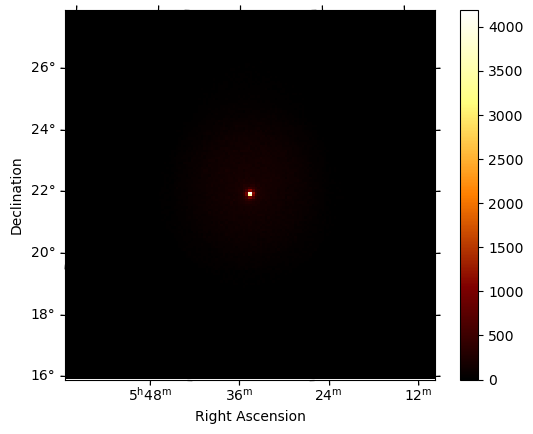

In [3]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/irf_model/config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = 0.0
sigma = 0.0
sigmass = [0.01, 0.02, 0.03, 0.04]


datasets = []
datasets_N = []

for sigmas in sigmass:

    sys = sys_dataset(dataset_asimov= dataset_asimov,
                            shift = 0, 
                            tilt = 0,
                              bias = bias, 
                             sigma = sigma,
                            rnd = False,
                     e_reco_creation=10)
    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4, 4))
    if bias ==0 :
        b_ = zero
    else:
        b_ = bias
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigmas**2])

    dataset = sys.create_dataset()
    dataset_N = sys.create_dataset_N(e_reco_n = 10)
    dataset_N.models.parameters['bias'].frozen = True

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix


    for p in ['amplitude', 'norm', 'tilt', 'sigma']:
        dataset_N.models.parameters[p].frozen = True
        dataset.models.parameters[p].frozen = True

    datasets.append(dataset)
    datasets_N.append(dataset_N)



in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10


In [5]:
%%time
fits = []
for dataset in datasets:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)
    print(result)
    
    fits.append(fit)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 28
	total stat : -753580.09

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 28
	total stat : -753580.09

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 28
	total stat : -753580.09

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminat

In [6]:
%%time
fits_N = []
for dataset_N in datasets_N:
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(dataset_N)
    fits_N.append(fit_N)

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.42387228729048754
evaluate: 0.42387228729048754 0.0
10
in map: -0.42387228729048754
evaluate: -0.42387228729048754 0.0
10
in map: 0.04238722872904876
evaluate: 0.04238722872904876 0.0
10
in map: -0.04238722872904876
evaluate: -0.04238722872904876 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.04238722872904876
evaluate: 0.04238722872904876 0.0
10
in map: -0.04238722872904876
evaluate: -0.04238722872904876 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0029922094402394816
evaluate: 0.0029922094402394816 0.0
10
in map: -0.0029922094402394816
evaluate: -0.0029922094402394816 0.0
10
in

in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 4.913555712771004e-07
evaluate: 4.913555712771004e-07 0.0
10
in map: -4.907766781884529e-07
evaluate: -4.907766781884529e-07 0.0
10
in map: 2.455620070208207e-06
evaluate: 2.455620070208207e-06 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.8944654432377885e-10
evaluate: 2.8944654432377885e-10 0.0
10
in map: 2.

In [7]:
fits[0].minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 28               │
│ EDM = 8.8e-12 (Goal: 0.0002)     │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index │   2.30    │   0.04    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬───────────────┐
│               │ par_000_index │
├───────────────┼───────────────┤
│ par_000_index │       0.00194 │
└───────────────┴───────────────┘

In [8]:
fits_N[0].minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 44               │
│ EDM = 1.43e-11 (Goal: 0.0002)    │           time = 13.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index      │   2.30    │   0.04    │            │            │         │         │       │
│ 1 │ par_001_resolution │   -0.00   │   0.01    │            │            │         │         │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬───────────────────────────────────────┐
│                    │      par_000_index par_001_resolution │
├────────────────────┼───────────────────────────────────────┤
│      par_000_index │            0.00194           4.16e-09 │
│ par_001_resolution │           4.16e-09             0.0001 │
└────────────────────┴───────────────────────────────────────┘

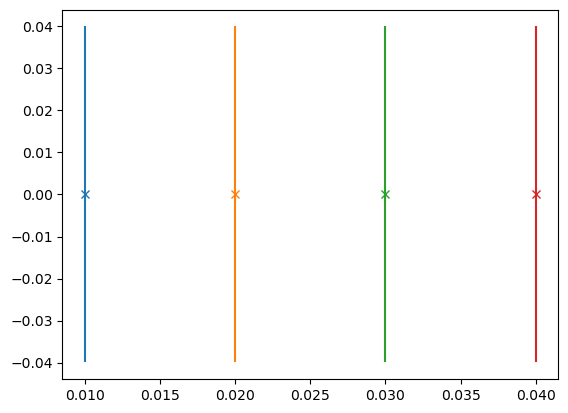

In [9]:
for i, d in enumerate( datasets_N):
    value = d.irf_model.parameters['resolution'].value
    error = d.irf_model.parameters['resolution'].error
    plt.errorbar(sigmass[i], value, yerr = error, fmt = 'x')
    

# Stat Contours

In [10]:
'''%%time
xs, ys, ss = [], [], []
xs_N, ys_N, ss_N = [], [], []

for fit in fits:
    ## mn profile reoptimizes and profile does not
    x, y, s = fit.minuit.mnprofile("par_000_index", size = 11, bound = 4)
    xs.append(x); ys.append(y); ss.append(s)

for fit_N in fits_N:
    x_N, y_N , s_N= fit_N.minuit.mnprofile("par_000_index", size = 11, bound = 4)
    xs_N.append(x_N); ys_N.append(y_N); ss_N.append(s_N)
print(x_N, y_N , s_N)

'''

'%%time\nxs, ys, ss = [], [], []\nxs_N, ys_N, ss_N = [], [], []\n\nfor fit in fits:\n    ## mn profile reoptimizes and profile does not\n    x, y, s = fit.minuit.mnprofile("par_000_index", size = 11, bound = 4)\n    xs.append(x); ys.append(y); ss.append(s)\n\nfor fit_N in fits_N:\n    x_N, y_N , s_N= fit_N.minuit.mnprofile("par_000_index", size = 11, bound = 4)\n    xs_N.append(x_N); ys_N.append(y_N); ss_N.append(s_N)\nprint(x_N, y_N , s_N)\n\n'

In [11]:
'''

plt.plot(x, y,label = 'st');

for i in range(len(sigmass)):
    plt.plot(xs_N[i], ys_N[i],label = f'nui, $\sigma$={sigmass[i]}');
plt.legend()'''

"\n\nplt.plot(x, y,label = 'st');\n\nfor i in range(len(sigmass)):\n    plt.plot(xs_N[i], ys_N[i],label = f'nui, $\\sigma$={sigmass[i]}');\nplt.legend()"

In [12]:
grid = np.linspace(-0.04, 0.04, 11)

In [13]:
for d in datasets_N:
    print("best fit res:", d.irf_model.parameters['resolution'].value)
    print("error res:", d.irf_model.parameters['resolution'].error)
    
    print("Penalty", 1/np.sqrt(d.penalising_invcovmatrix[-1][-1]))
    print()

best fit res: -1.2687882268391155e-09
error res: 0.039972859949357085
Penalty 0.01

best fit res: -1.2687882268391155e-09
error res: 0.039972859949357085
Penalty 0.02

best fit res: -1.2687882268391155e-09
error res: 0.039972859949357085
Penalty 0.03

best fit res: -1.2687882268391155e-09
error res: 0.039972859949357085
Penalty 0.04



In [14]:
%%time
xs_Nass, ys_Nass, ss_Nass = [], [], []
for fit_N in fits_N:
    x_Nass, y_Nass , s_Nass= fit_N.minuit.mnprofile("par_001_resolution", 
                                                    grid = grid)
                                                    #size = 11, bound = 4)
    xs_Nass.append(x_Nass); ys_Nass.append(y_Nass); ss_Nass.append(s_Nass)
print(x_Nass, y_Nass , s_Nass)

in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: -4e-12 0.0
10
in map: -4e-12
evaluate: 

in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 8e-13
evaluate: 8e-13 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.6e-12
evaluate: 1.6e-12 0.0
10
in map: 1.

in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.2e-12
evaluate: -3.2e-12 0.0
10
in map: -3.

in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map: 2.4000000000000003e-12
evaluate: 2.4000000000000003e-12 0.0
10
in map

in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -2.4000000000000003e-12
evaluate: -2.4000000000000003e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6e-12
evaluate: -1.6e-12 0.0
10
in map: -1.6

in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
evaluate: 3.200000000000001e-12 0.0
10
in map: 3.200000000000001e-12
eval

in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: -8e-13
evaluate: -8e-13 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
i

KeyboardInterrupt: 

IndexError: list index out of range

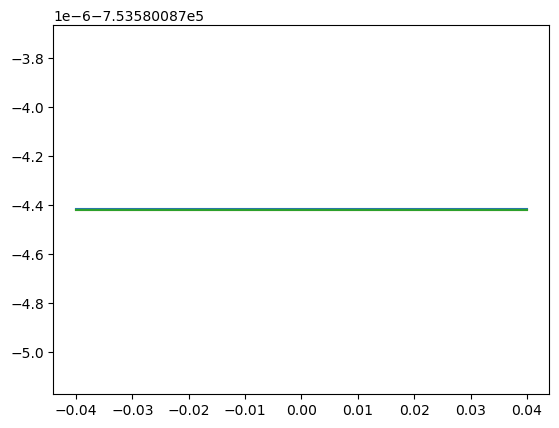

In [15]:

for i in range(len(sigmass)):
    plt.plot(xs_Nass[i], ys_Nass[i],label = f'nui, $\sigma$={sigmass[i]}');
plt.legend()

In [ ]:
%%time
xs_Nass_b2, ys_Nass_b2, ss_Nass_b2 = [], [], []
for fit_N in fits_N:
    x_Nass_b2, y_Nass_b2 , s_Nass_b2= fit_N.minuit.mnprofile("par_001_resolution", size = 11, bound = 2)
    xs_Nass_b2.append(x_Nass_b2); ys_Nass_b2.append(y_Nass_b2); ss_Nass_b2.append(s_Nass_b2)
print(x_Nass_b2, y_Nass_b2 , s_Nass_b2)

In [ ]:
fig, axs = plt.subplots(2,3)

for i in range(len(sigmass)):
    axs.flatten()[i].plot(xs_Nass_b2[i], ys_Nass_b2[i],label = f'nui, $\sigma$={sigmass[i]}');
    axs.flatten()[i].legend()

In [ ]:
%%time
mncontour_0 = fits_N[2].minuit.mncontour('par_001_resolution', 'par_000_index', size=20, interpolated=200)

In [ ]:
x, y = np.transpose(mncontour_0)
plt.plot(x, y, "o-");